# Person Recognition with Deep Learning

Simple algorithm for person recognition


<img src="https://i.imgur.com/2WynUUt.png"/> 

# 1. Loading and preprocessing<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
train_dir = Path('./output/train')
test_dir = Path('./output/valid')

# Get filepaths and labels
filepaths_train = list(train_dir.glob(r'**/*.jpg'))
filepaths_test = list(test_dir.glob(r'**/*.jpg'))

In [3]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(filepaths_train)
test_df = proc_img(filepaths_test)


# Show the result
train_df.head(5)

Filepath              Label
0               output/train/Cher/000028.jpg               Cher
1       output/train/Susan Sontag/000005.jpg       Susan Sontag
2  output/train/Katharine Hepburn/000002.jpg  Katharine Hepburn
3   output/train/Katharine Graham/000039.jpg   Katharine Graham
4       output/train/Katia Krafft/000047.jpg       Katia Krafft

In [4]:
print(f'Number of training pictures: {train_df.shape[0]}')
print(f'Number of test pictures: {test_df.shape[0]}')

Number of training pictures: 2652
Number of test pictures: 494


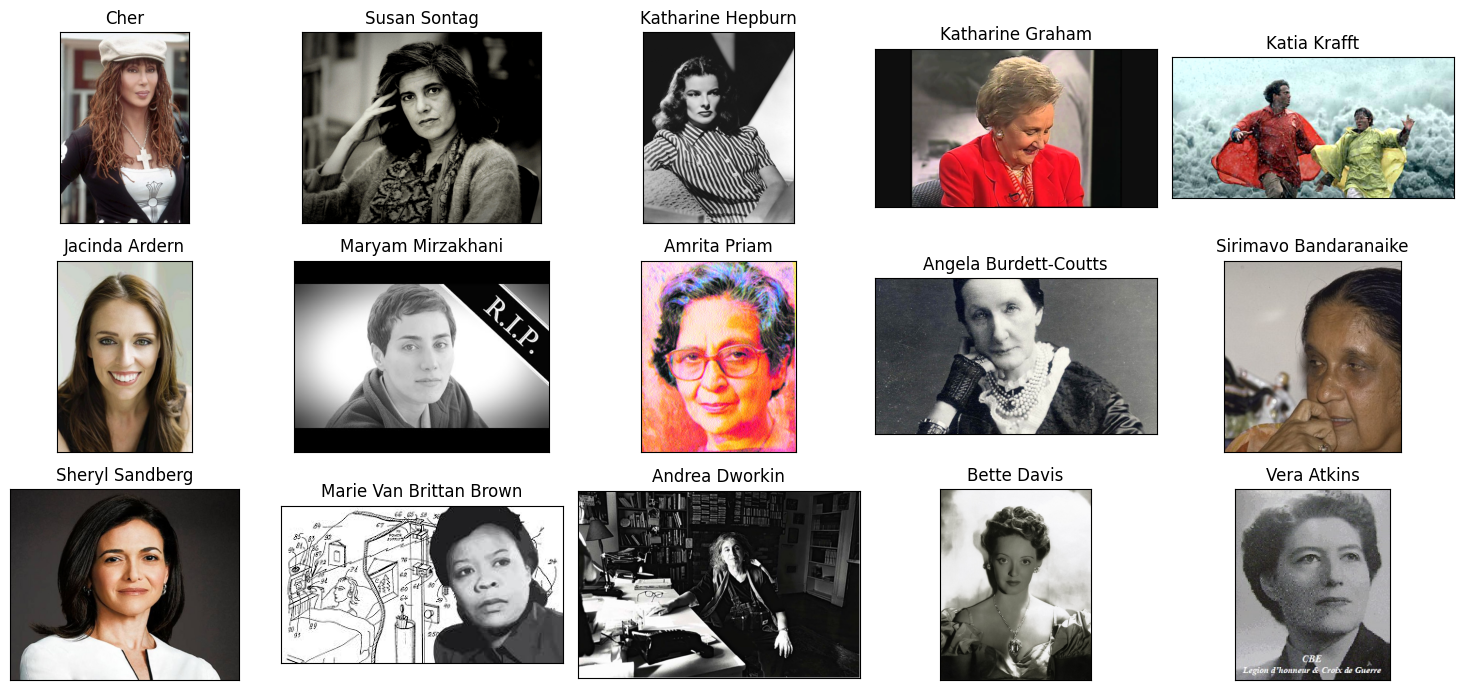

In [5]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a>

Having in total around 3000 pictures with 64 different women, this makes around 50 pictures/woman. Taking in consideration that the pictures are from very different perspectives and backrounds, 50 isn't a lot. The Data Augmentation on the fly, will generate new pictures by changing a bit each picture.

In [6]:
# This code fix an error, which would occur during the training otherwise
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2122 validated image filenames belonging to 64 classes.
Found 530 validated image filenames belonging to 64 classes.
Found 494 validated image filenames belonging to 64 classes.


In [9]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


# 3. Train the model<a class="anchor" id="3"></a>

In [10]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(64, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - accuracy: 0.0565 - loss: 4.0915 - val_accuracy: 0.2604 - val_loss: 3.2606
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.3916 - loss: 2.6198 - val_accuracy: 0.4057 - val_loss: 2.3432
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.6189 - loss: 1.5237 - val_accuracy: 0.5113 - val_loss: 1.8864
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.7549 - loss: 0.9717 - val_accuracy: 0.5585 - val_loss: 1.7613
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.8673 - loss: 0.6060 - val_accuracy: 0.5698 - val_loss: 1.6897
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.9239 - loss: 0.4039 - val_accuracy: 0.5925 - val_loss: 1.6867
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.9647 - loss: 0.2742 - val_accuracy: 0.6057 - val_loss: 1.6249
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.9818 - loss: 0.1789 - val_accuracy: 0.624

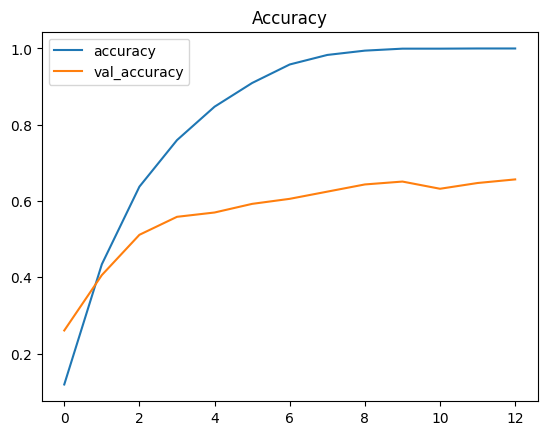

In [11]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

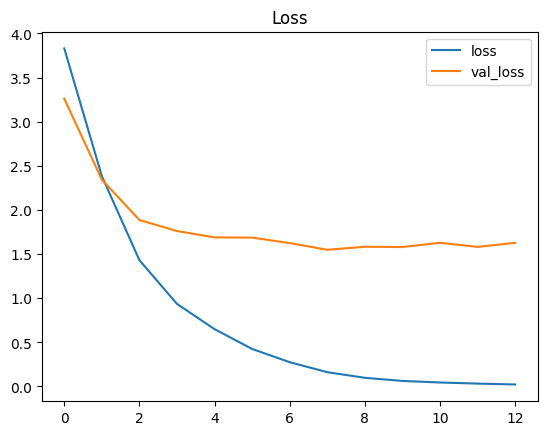

In [12]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 4. Visualize the result<a class="anchor" id="4"></a>

In [13]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 1.53658
Test Accuracy: 64.37%


In [14]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
The first 5 predictions: ['Wilma Rudolph', 'Mary Wollstonecraft', 'Anna Akhmatova', 'Cher', 'Kamala Harris']


In [15]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                          precision    recall  f1-score   support

            Ada Lovelace       1.00      1.00      1.00         8
           Alice Milliat       0.57      0.67      0.62         6
          Amelia Earhart       0.50      0.62      0.56         8
            Amrita Priam       0.80      0.67      0.73         6
          Andrea Dworkin       0.83      0.62      0.71         8
   Angela Burdett-Coutts       0.50      0.71      0.59         7
           Angela Merkel       0.50      0.86      0.63         7
          Anna Akhmatova       0.55      0.75      0.63         8
         Aretha Franklin       0.60      0.38      0.46         8
          Audrey Hepburn       0.60      0.38      0.46         8
          Bessie Coleman       0.83      0.71      0.77         7
             Bette Davis       0.19      0.50      0.28         8
             Betty White       0.44      0.50      0.47         8
          Buchi Emecheta       0.50      0.50      0.50         6
         

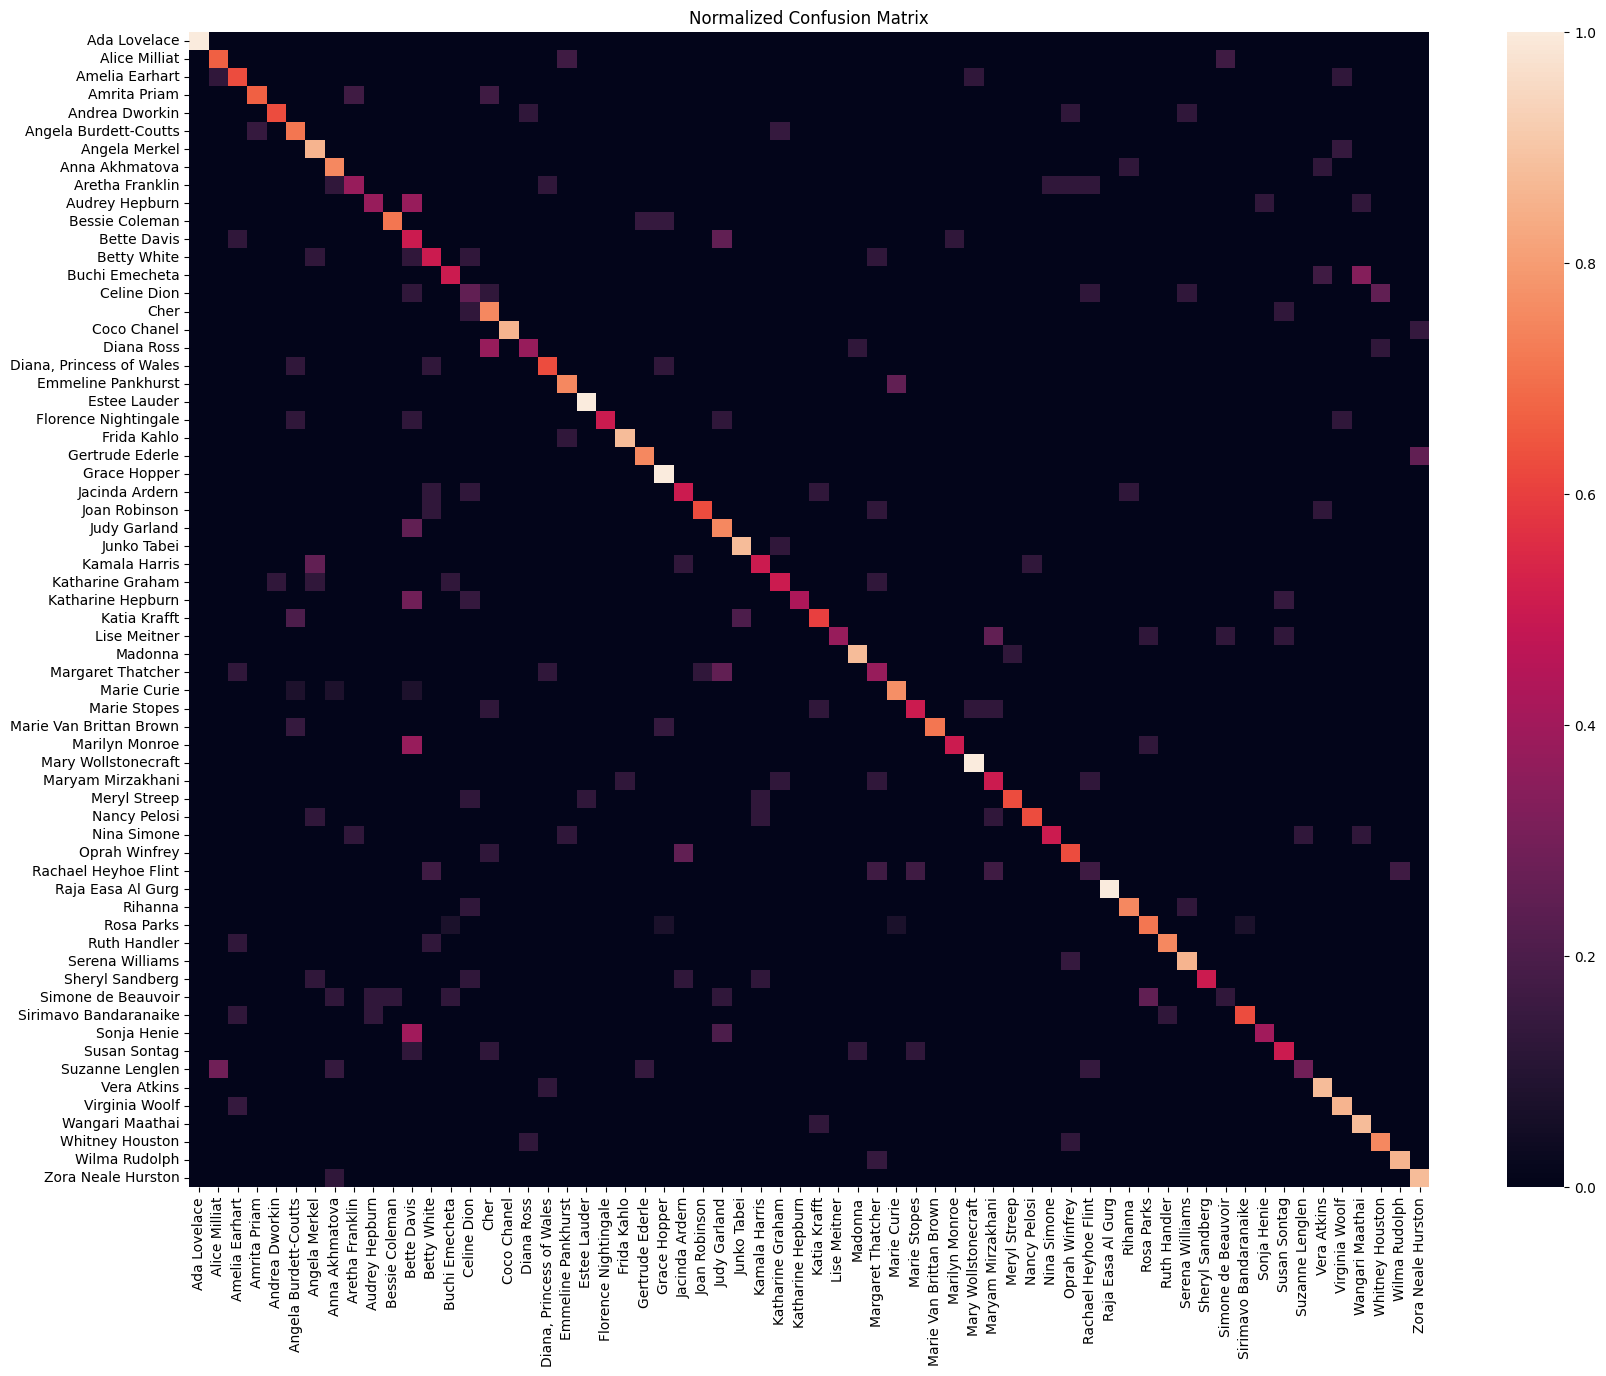

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

# Examples of prediction

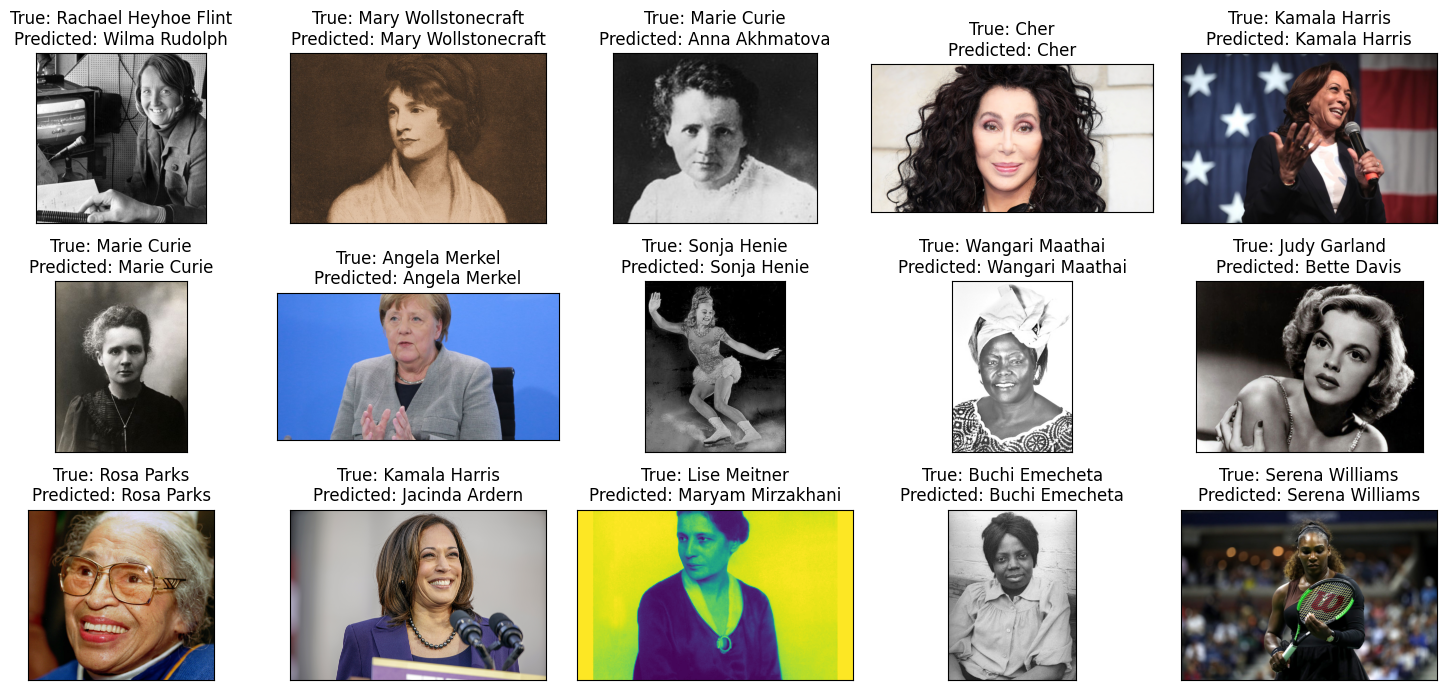

In [17]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 5. Visualization of some pictures<a class="anchor" id="5"></a>

In [18]:
def show_by_label(label):
    """Display some pictures of the dataset by label    
    """
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        tmp = train_df[train_df.Label == label]['Filepath'].iloc[i]
        ax.imshow(plt.imread(tmp))
    plt.tight_layout()
    plt.show()


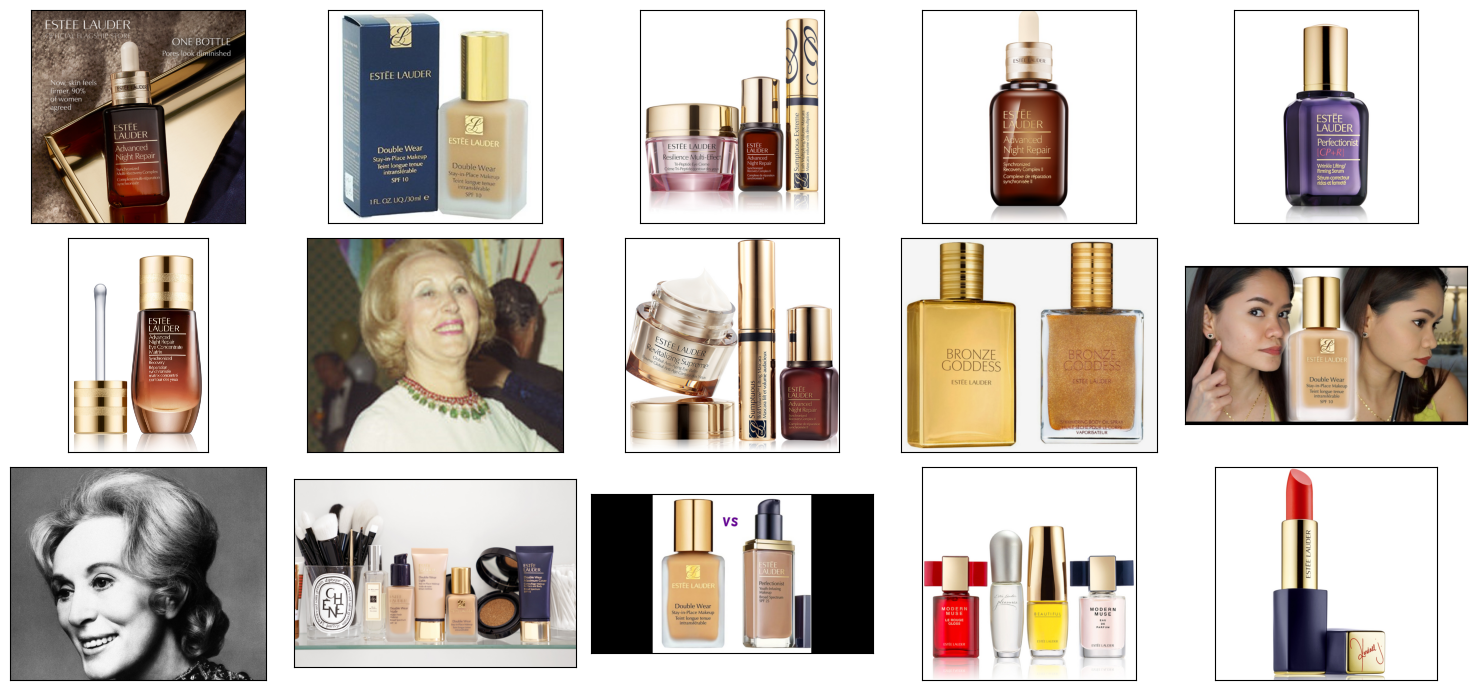

In [19]:
# The label "Estee Lauder" doesn't show the woman behind the brand but her products
show_by_label('Estee Lauder')

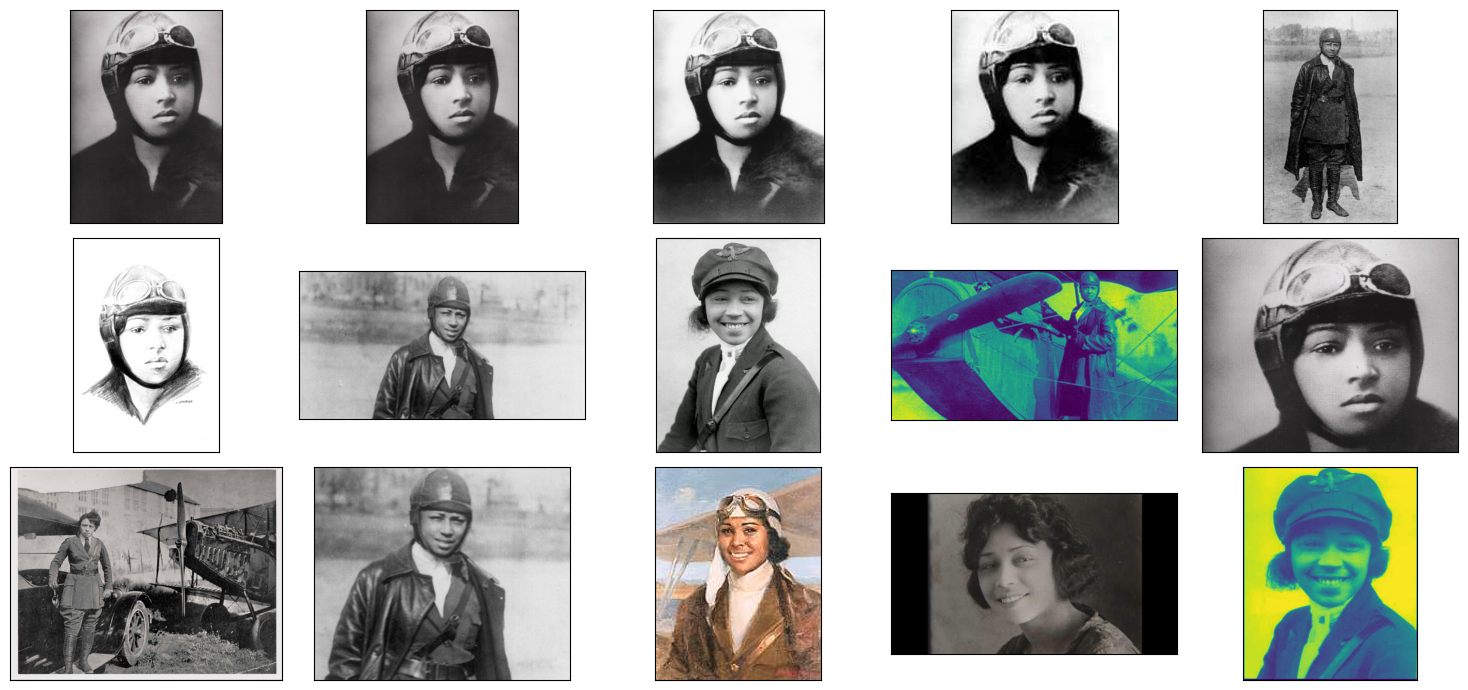

In [20]:
# It seems that Data Augmentation has been used
# some pictures are duplicated by changing the zoom or the colours
show_by_label('Bessie Coleman')